In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.2)
response = llm.invoke("What is artificial intelligence?")
print(response.content)

Artificial intelligence (AI) is a broad field of computer science focused on **creating systems that can perform tasks that typically require human intelligence.** This includes things like:

*   **Learning:** Acquiring knowledge and skills from data.
*   **Problem-solving:** Finding solutions to complex challenges.
*   **Decision-making:** Choosing the best course of action based on available information.
*   **Perception:** Understanding and interpreting sensory input (like images, sounds, and text).
*   **Language understanding and generation:** Communicating in human languages.
*   **Reasoning:** Drawing logical conclusions.
*   **Creativity:** Generating new ideas or content.

**Think of it as building "smart" machines.** Instead of being explicitly programmed for every single scenario, AI systems are designed to adapt, learn, and improve over time.

**Key Concepts and Components of AI:**

*   **Machine Learning (ML):** This is a subfield of AI that allows systems to learn from da

In [4]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert sommelier who only speaks in elegant, short phrases."),
    ("human", "I'm having a dinner party with {food}. What wine should I serve?")
])

# Create the chain: Prompt -> LLM
chain = prompt | llm

# Invoke the chain
response = chain.invoke({"food": "spicy tacos"})

print(response.content)

Chilled Riesling.
Or, crisp Sauvignon Blanc.
Perhaps a light, fruity Beaujolais.


In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
# Using messages for more control
messages = [
    SystemMessage(content="You are a helpful AI assistant that explains complex topics simply."),
    HumanMessage(content="Explain machine learning in 2 sentences.")
]

response = llm.invoke(messages)
response

AIMessage(content='Machine learning is a way for computers to learn from data without being explicitly programmed. It uses algorithms to find patterns and make predictions or decisions based on that data.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--53cfb6a1-3078-4bdf-9862-5d7c42f313f8-0', usage_metadata={'input_tokens': 21, 'output_tokens': 32, 'total_tokens': 53, 'input_token_details': {'cache_read': 0}})

In [6]:
print(response.content)

Machine learning is a way for computers to learn from data without being explicitly programmed. It uses algorithms to find patterns and make predictions or decisions based on that data.


In [3]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

In [5]:
@tool
def calculator(expression: str) -> str:
    """Calculate mathematical expressions. Use this for any math calculations."""
    try:
        result = eval(expression)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"

search_tool = DuckDuckGoSearchRun()

# Bind tools to the LLM
tools = [calculator, search_tool]
llm_with_tools = llm.bind_tools(tools)

# Test the calculator tool
print("Testing Calculator Tool:")
response = llm_with_tools.invoke("What's 25 * 4 + 17?")
print(f"Response: {response.content}")

Testing Calculator Tool:
Response: 


In [6]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"expression": "25 * 4 + 17"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--f1b4555f-40d1-4c0a-827f-edae502268b0-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '25 * 4 + 17'}, 'id': 'af6b9d88-8ddb-412f-b5b6-220f87ff6d5f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 121, 'output_tokens': 21, 'total_tokens': 142, 'input_token_details': {'cache_read': 0}})

In [7]:
# Map tool names to tool objects for dynamic execution
tool_map = {
    'calculator': calculator,
    'duckduckgo_search': search_tool,
}

def handle_tool_calls(response, tool_map):
    """Executes all tool calls in the LLM response using the tool_map."""
    if not getattr(response, 'tool_calls', None):
        return

    print(f"Tool calls requested: {len(response.tool_calls)}")
    for tool_call in response.tool_calls:
        tool_name = tool_call['name']
        args = tool_call['args']
        print(f"Tool: {tool_name}")
        print(f"Args: {args}")

        tool = tool_map.get(tool_name)
        if tool:
            result = tool.invoke(args)
            # Print first 200 chars for long responses (e.g., search)
            preview = result[:200] + "..." if isinstance(result, str) and len(result) > 200 else result
            print(f"Tool result: {preview}")

In [8]:
def test_llm_tool(query):
    print(f"Query: {query}")
    response = llm_with_tools.invoke(query)
    print(f"Response: {getattr(response, 'content', response)}")
    handle_tool_calls(response, tool_map)
    print("\n")

test_llm_tool("What's 25 * 4 + 17?")
test_llm_tool("Search for recent news about artificial intelligence")

Query: What's 25 * 4 + 17?
Response: 
Tool calls requested: 1
Tool: calculator
Args: {'expression': '25 * 4 + 17'}
Tool result: The result of 25 * 4 + 17 is 117


Query: Search for recent news about artificial intelligence
Response: 
Tool calls requested: 1
Tool: duckduckgo_search
Args: {'query': 'recent news about artificial intelligence'}
Tool result: 3 days ago · Explore the latest artificial intelligence news with Reuters - from AI breakthroughs and technology trends to regulation, ethics, business and global impact. AI News reports on the latest...




In [9]:
from pydantic import BaseModel, Field
from typing import List, Optional

In [10]:
class PersonInfo(BaseModel):
    """Information about a person"""
    name: str = Field(description="Full name of the person")
    age: Optional[int] = Field(description="Age of the person")
    occupation: str = Field(description="Person's job or profession")
    skills: List[str] = Field(description="List of skills or expertise")

structured_llm = llm.with_structured_output(PersonInfo)

# Test with person information
print("Testing Structured Output - Person Info:")
person_prompt = """
Extract information about this person:
"John Smith is a 35-year-old software engineer who works at Google.
He specializes in machine learning, Python programming, and cloud architecture.
John has been working in tech for over 10 years and is passionate about AI research."
"""

person_result = structured_llm.invoke(person_prompt)
print(f"Name: {person_result.name}")
print(f"Age: {person_result.age}")
print(f"Occupation: {person_result.occupation}")
print(f"Skills: {', '.join(person_result.skills)}")

Testing Structured Output - Person Info:
Name: John Smith
Age: 35
Occupation: Software Engineer
Skills: Machine Learning, Python Programming, Cloud Architecture


In [11]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [12]:
class State(TypedDict):
    """State for our chatbot - this holds the conversation history"""
    # The add_messages function handles appending new messages to the conversation
    messages: Annotated[list[BaseMessage], add_messages]


In [13]:
def chatbot_node(state: State) -> State:
    """
    The main chatbot node that processes messages and generates responses
    """
    print(f"Processing {len(state['messages'])} messages")

    # Get the response from the LLM
    response = llm.invoke(state["messages"])

    # Return the updated state with the new response
    return {"messages": [response]}

print("Chatbot node function created")

Chatbot node function created


In [14]:
from langgraph.graph import StateGraph, START, END

In [15]:
graph_builder = StateGraph(State)

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot_node)

# Define the flow: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

print("Graph structure created")
print("Graph compiled successfully")

Graph structure created
Graph compiled successfully


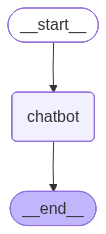

In [17]:
graph_builder.compile()

In [20]:
graph.invoke({"messages": [HumanMessage(content="Hello, who won the world series in 2020?")]})

Processing 1 messages


{'messages': [HumanMessage(content='Hello, who won the world series in 2020?', additional_kwargs={}, response_metadata={}, id='32952ff6-0e1e-40a4-9eb8-9c3634473780'),
  AIMessage(content='The **Los Angeles Dodgers** won the World Series in 2020.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--6324bdc2-3851-412a-a635-7283195ab473-0', usage_metadata={'input_tokens': 15, 'output_tokens': 17, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [21]:
from langgraph.checkpoint.memory import MemorySaver

In [23]:
memory = MemorySaver()

# Compile the graph with memory
graph_with_memory = graph_builder.compile(checkpointer=memory)

print("Memory added to chatbot")

def chat_with_memory(message: str, thread_id: str):
    """Chat function with memory"""
    print(f"\n👤 User: {message}")

    # Configuration for the thread
    config = {"configurable": {"thread_id": thread_id}}

    # Add the user message to the conversation
    initial_state = {"messages": [HumanMessage(content=message)]}

    # Run the graph with memory
    result = graph_with_memory.invoke(initial_state, config)

    # Get the AI response
    ai_response = result["messages"][-1].content
    print(f"Thread-id: {thread_id} 🤖 Assistant: {ai_response}")


# Test conversation with memory
print("\nTesting Conversation with Memory:")

# Start a conversation
chat_with_memory("Hi, my name is rudraksh", thread_id="thread-1")
chat_with_memory("What's my name?", thread_id="thread-1")

Memory added to chatbot

Testing Conversation with Memory:

👤 User: Hi, my name is rudraksh
Processing 1 messages
Thread-id: thread-1 🤖 Assistant: Hi Rudraksh, it's nice to meet you! How can I help you today?

👤 User: What's my name?
Processing 3 messages
Thread-id: thread-1 🤖 Assistant: Your name is Rudraksh.


In [24]:
class AgentState(TypedDict):
    """State for our two-node agent"""
    messages: Annotated[list[BaseMessage], add_messages]

# Initialize LLM with tools
llm_with_tools = llm.bind_tools(tools)

In [25]:
def chatbot_node(state: AgentState) -> AgentState:
    """
    The chatbot node that decides whether to use tools or provide direct responses
    """
    messages = state["messages"]

    # Add system prompt
    system_message = """You are a helpful AI assistant. You have access to web search and calculator tools.

    Use the web_search tool when:
    - Asked about current events, news, or recent information
    - Need to find specific facts or data
    - Asked about real-time information (weather, stock prices, etc.)

    Use the calculator tool when:
    - Asked to perform mathematical calculations
    - Need to solve math problems

    For general knowledge questions that don't require real-time data, answer directly.
    Be helpful and conversational in your responses."""

    # Prepare messages with system prompt
    all_messages = [{"role": "system", "content": system_message}] + messages

    # Get response from LLM
    response = llm_with_tools.invoke(all_messages)

    return {"messages": [response]}

print("Chatbot node created")

Chatbot node created


In [26]:
from langgraph.prebuilt import ToolNode
from typing import Literal

In [27]:
tools

[StructuredTool(name='calculator', description='Calculate mathematical expressions. Use this for any math calculations.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calculator at 0x00000169ECC93BA0>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))]

In [28]:
tool_node = ToolNode(tools)

print("Tool node created")


Tool node created


In [29]:

def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """
    Determine whether to continue to tools or end the conversation
    """
    messages = state["messages"]
    last_message = messages[-1]

    # If the last message has tool calls, go to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    # Otherwise, end the conversation
    else:
        return "end"

print("Routing logic created")

Routing logic created


Graph compiled with memory



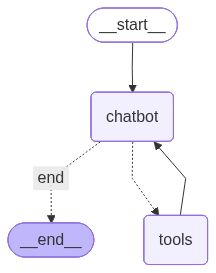

In [30]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.add_edge(START, "chatbot")

# Add conditional edges
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools",
        "end": END,
    },
)

# After using tools, go back to chatbot
workflow.add_edge("tools", "chatbot")

# Compile the graph
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("Graph compiled with memory\n")

workflow.compile(checkpointer=memory)


In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
def chat_with_agent(message: str, thread_id: str):
    """Chat with the two-node agent"""
    print(f"\n👤 User: {message}")

    config = {"configurable": {"thread_id": thread_id}}

    # Stream the response to see the process
    messages_to_process = {"messages": [HumanMessage(content=message)]}

    for event in app.stream(messages_to_process, config):
        for value in event.values():
            if "messages" in value:
                last_message = value["messages"][-1]
                if hasattr(last_message, 'content') and last_message.content:
                    if isinstance(last_message, AIMessage):
                        print(f"🤖 Assistant: {last_message.content}")
                    elif isinstance(last_message, ToolMessage):
                        print(f"🔧 Tool Result: {last_message.content[:100]}...")

while True:
    user_input = input("User: ")
    if user_input.lower() == "exit":
        break
    chat_with_agent(user_input, thread_id="thread-2")


👤 User: What's 15% of 240?
🤖 Assistant: 15% of 240 is 36.

👤 User: What's the latest news about artificial intelligence?
🔧 Tool Result: 2 hours ago — ARTIFICIAL INTELLIGENCE NEWS · AI 'workslop' may be destroying your productivity , sug...
🤖 Assistant: The latest news about artificial intelligence includes:

*   A new Harvard study suggests that AI "workslops" might be harming productivity.
*   Sam Altman claims that Artificial General Intelligence (AGI) will take over 40% of tasks.
*   SoftBank's chief predicts that Artificial Superintelligence (ASI) will arrive within 10 years, even sooner than AGI.
*   Malaysia has launched its first AI-powered bank, Ryt Bank.
*   Google's Veo 3 AI tools for video creation are being discussed.
*   CoreWeave, an AI cloud provider, has expanded its partnership with OpenAI with a new deal worth up to $6.5 billion.
*   Elon Musk's xAI has filed a lawsuit accusing OpenAI of stealing trade secrets.
*   There's a mention of deepfakes and "slopaganda" in r

# langgraph

In [52]:

# ── Imports ───────────────────────────────────────────────────────────
from pathlib import Path
from typing   import List
from langchain_community.document_loaders import (
    PyPDFLoader, Docx2txtLoader, TextLoader, UnstructuredMarkdownLoader
)
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage,BaseMessage
from langgraph.prebuilt import ToolNode
from typing import Literal
from langgraph.graph import StateGraph, START, END
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver

In [6]:
def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 5 documents from the folder.


In [7]:
documents[0]

Document(metadata={'source': 'docs\\Company_ GreenFields BioTech.docx'}, page_content='Company: GreenFields BioTech\n\nHeadquarters: GreenFields BioTech is headquartered in Zurich, Switzerland. Known for its groundbreaking research in sustainable agriculture and biotechnology, the company has strategically positioned itself in Zurich, a city recognized for its leadership in scientific research and innovation. This location provides GreenFields BioTech with an ideal environment to collaborate with leading academic institutions and industry experts, driving forward its mission to create eco-friendly farming solutions.')

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

chunks = text_splitter.split_documents(documents)
print(f"Split the documents into {len(chunks)} chunks.")

Split the documents into 8 chunks.


In [14]:
# ── Config ────────────────────────────────────────────────────────────
SOURCE_DIR   = Path("docs")             # put your files here
INDEX_DIR    = Path("chroma_db_1")        # will be created if missing
COLLECTION   = "kb_collection"
EMBED_MODEL  = "gemini-embedding-001"

embeddings = GoogleGenerativeAIEmbeddings(model=EMBED_MODEL)
vectordb   = Chroma.from_documents(
    documents         = chunks,
    embedding         = embeddings,
    persist_directory = str(INDEX_DIR),
    collection_name   = COLLECTION,
)
vectordb.persist()
print("Index built at", INDEX_DIR.resolve())

Index built at D:\couses\project\langchain\nrml chat bot campusx\chroma_db_1


In [15]:
retriever = vectordb.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("When was GreenGrow Innovations founded?")
retriever_results

[Document(metadata={'source': 'docs\\GreenGrow Innovations_ Company History.docx'}, page_content='GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.\n\n\n\nIn its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.\n\n\n\nBy 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors to analyz

In [25]:
from dotenv import load_dotenv
import os

load_dotenv()
from langchain_tavily  import TavilySearch
tavily = TavilySearch(max_results=3, topic="general")


In [34]:
tavily.invoke({"query": "what are ransformers in ai"})

{'query': 'what are ransformers in ai',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/what-is/transformers-in-artificial-intelligence/',
   'title': 'What are Transformers in Artificial Intelligence?',
   'content': 'For example, consider this input sequence: "What is the color of the sky?" The transformer model uses an internal mathematical representation that identifies the relevancy and relationship between the words color, sky, and blue. Organizations use transformer models for all types of sequence conversions, from speech recognition to machine translation and protein sequence analysis. The encoder reads and processes the entire input data sequence, such as an English sentence, and transforms it into a compact mathematical representation. Transformer models and RNNs are both architectures used for processing sequential data. This parallelization enables much faster training times and the ability to handle much longer se

In [31]:

@tool
def web_search_tool(query: str) -> str:
    """Up-to-date web info via Tavily"""
    try:
        result = tavily.invoke({"query": query})

        # Extract and format the results from Tavily response
        if isinstance(result, dict) and 'results' in result:
            formatted_results = []
            for item in result['results']:
                title = item.get('title', 'No title')
                content = item.get('content', 'No content')
                url = item.get('url', '')
                formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}")

            return "\n\n".join(formatted_results) if formatted_results else "No results found"
        else:
            return str(result)
    except Exception as e:
        return f"WEB_ERROR::{e}"

@tool
def rag_search_tool(query: str) -> str:
    """Top-3 chunks from KB (empty string if none)"""
    try:
        docs = retriever.invoke(query, k=3)
        return "\n\n".join(d.page_content for d in docs) if docs else ""
    except Exception as e:
        return f"RAG_ERROR::{e}"

In [35]:
print(web_search_tool.invoke("what are ransformers in ai"))

Title: What are Transformers in Artificial Intelligence?
Content: For example, consider this input sequence: "What is the color of the sky?" The transformer model uses an internal mathematical representation that identifies the relevancy and relationship between the words color, sky, and blue. Organizations use transformer models for all types of sequence conversions, from speech recognition to machine translation and protein sequence analysis. The encoder reads and processes the entire input data sequence, such as an English sentence, and transforms it into a compact mathematical representation. Transformer models and RNNs are both architectures used for processing sequential data. This parallelization enables much faster training times and the ability to handle much longer sequences than RNNs. The self-attention mechanism in transformers also enables the model to consider the entire data sequence simultaneously.
URL: https://aws.amazon.com/what-is/transformers-in-artificial-intellige

In [38]:
# ── Pydantic schemas ─────────────────────────────────────────────────
class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: str | None = Field(None, description="Filled only when route == 'end'")

class RagJudge(BaseModel):
    sufficient: bool

In [41]:
# ── LLM instances with structured output where needed ───────────────
router_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0).with_structured_output(RouteDecision)
judge_llm  = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0).with_structured_output(RagJudge)
answer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.7)

In [46]:
# ── Shared state type ────────────────────────────────────────────────
class AgentState(TypedDict, total=False):
    messages: List[BaseMessage]
    route:    Literal["rag", "answer", "end"]
    rag:      str
    web:      str

In [ ]:
# ── Node 1: decision/router ─────────────────────────────────────────
def router_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    # Use structured output properly - pass messages directly
    messages = [
        ("system", (
            "You are a router that decides how to handle user queries:\n"
            "- Use 'end' for pure greetings/small-talk (also provide a 'reply')\n"
            "- Use 'rag' when knowledge base lookup is needed\n"
            "- Use 'answer' when you can answer directly without external info"
        )),
        ("user", query)
    ]

    result: RouteDecision = router_llm.invoke(messages)

    out = {"messages": state["messages"], "route": result.route}
    if result.route == "end":
        out["messages"] = state["messages"] + [AIMessage(content=result.reply or "Hello!")]
    return out

In [48]:
# ── Node 2: RAG lookup ───────────────────────────────────────────────
def rag_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    chunks = rag_search_tool.invoke({"query": query})

    # Use structured output to judge if RAG results are sufficient
    judge_messages = [
        ("system", (
            "You are a judge evaluating if the retrieved information is sufficient "
            "to answer the user's question. Consider both relevance and completeness."
        )),
        ("user", f"Question: {query}\n\nRetrieved info: {chunks}\n\nIs this sufficient to answer the question?")
    ]

    verdict: RagJudge = judge_llm.invoke(judge_messages)

    return {
        **state,
        "rag": chunks,
        "route": "answer" if verdict.sufficient else "web"
    }

# ── Node 3: web search ───────────────────────────────────────────────
def web_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")
    snippets = web_search_tool.invoke({"query": query})
    return {**state, "web": snippets, "route": "answer"}


In [49]:
# ── Node 4: final answer ─────────────────────────────────────────────
def answer_node(state: AgentState) -> AgentState:
    user_q = next((m.content for m in reversed(state["messages"])
                   if isinstance(m, HumanMessage)), "")

    ctx_parts = []
    if state.get("rag"):
        ctx_parts.append("Knowledge Base Information:\n" + state["rag"])
    if state.get("web"):
        ctx_parts.append("Web Search Results:\n" + state["web"])

    context = "\n\n".join(ctx_parts) if ctx_parts else "No external context available."

    prompt = f"""Please answer the user's question using the provided context.

Question: {user_q}

Context:
{context}

Provide a helpful, accurate, and concise response based on the available information."""

    ans = answer_llm.invoke([HumanMessage(content=prompt)]).content

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=ans)]
    }

In [ ]:
# ── Routing helpers ─────────────────────────────────────────────────
def from_router(st: AgentState) -> Literal["rag", "answer", "end"]:
    return st["route"]

def after_rag(st: AgentState) -> Literal["answer", "web"]:
    return st["route"]

def after_web(_) -> Literal["answer"]:
    return "answer"



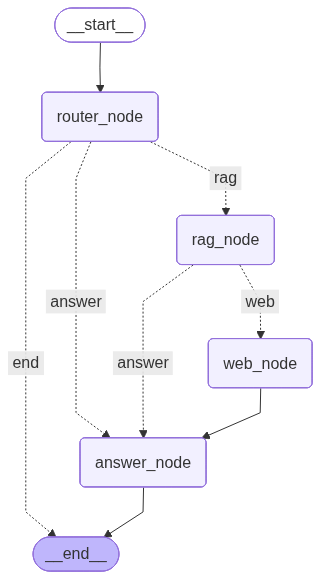

In [75]:
# ── Build graph ─────────────────────────────────────────────────────
g = StateGraph(AgentState)
g.add_node("router_node", router_node)
g.add_node("rag_node", rag_node)
g.add_node("web_node", web_node)
g.add_node("answer_node", answer_node)

g.set_entry_point("router_node")
g.add_conditional_edges("router_node", from_router,
                        {"rag": "rag_node", "answer": "answer_node", "end": END})
g.add_conditional_edges("rag_node", after_rag,
                        {"answer": "answer_node", "web": "web_node"})
g.add_edge("web_node",  "answer_node")
g.add_edge("answer_node", END)
agent = g.compile(checkpointer=MemorySaver())
g.compile(checkpointer=MemorySaver())




In [76]:
# ── Quick CLI test ───────────────────────────────────────────────────
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-12"}}
    print("RAG Agent CLI (type 'quit' or 'exit' to stop)")
    print("-" * 50)

    while True:
        q = input("\nYou: ").strip()
        if q.lower() in {"quit", "exit"}:
            break

        try:
            result = agent.invoke(
                {"messages": [HumanMessage(content=q)]},
                config=config
            )
            print(f'\n\nUser: {q}')
            # Get the last AI message
            last_message = next((m for m in reversed(result["messages"])
                               if isinstance(m, AIMessage)), None)

            if last_message:
                
                print(f"Agent: {last_message.content}")
            else:
                print("Agent: No response generated")

        except Exception as e:
            print(f"Error: {e}")

    print("\nGoodbye!")

RAG Agent CLI (type 'quit' or 'exit' to stop)
--------------------------------------------------


User: weather?
Agent: The weather in Harbour Island, Bahamas is partly cloudy with a temperature of 83.0°F (28.3°C). The wind is blowing from the west at 28.2 mph.

For Tuesday, September 30, 2025, there is a chance of showers and thunderstorms after 3 pm. The low is around 43°F. Wednesday will be sunny with a high near 71°F. Friday has a slight chance of showers and thunderstorms with a high near 69°F. Saturday and Saturday night have a slight chance of showers and thunderstorms. Sunday will have a slight chance of showers and thunderstorms with a high near 59°F.

In Hawaii County, there is a 20 percent chance of rain. Tonight will be partly cloudy with isolated showers in the evening, and lows ranging from 71-76°F near the shore to around 53°F at higher elevations.

Goodbye!
